# implementing Optimization iteration

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

" %matplotlib inline sets the backend of matplotlib to\nthe 'inline' backend. When using the 'inline' backend,\nyour matplotlib graphs will be included in your notebook,\nnext to the code."

In [2]:
from graphviz import Digraph

def trace(root):
    '''
    Build a set of all nodes and edges in a graph,
    the order does not matter
    '''
    nodes, edges = set(), set()
    
    def build(v): # a heuristic to get the nodes without order
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v)) # define edge like this
                build(child)

    build(root)
    return nodes, edges

# first have an scheme of your desired graph based on the nodes and operations
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR : left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular (record') node for it
        # a visual node
        dot.node(name=uid, label=f'{n.label} | data: {n.data} | grad: {n.grad}', shape='record')
        if n._op:
            # if this value is result of some operation, create an operation node for it
            dot.node(name=uid+n._op , label=n._op) # n._op is a string
            # and connect the op node to the value node
            dot.edge(uid+n._op , uid)
            for child in n._prev:
                dot.edge( str(id(child)) , uid+n._op)
    return dot

## A NN that subscribes to the PyTorch api

In [3]:
# we have our class Value
class Value:
    
    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self._prev = set(_prev) # the order does not matter, use set instead of list
        self._op = _op
        self.label = label

        self.grad = 0.0

        # After the forwrd path (when we have the data vlaue of all nodes)
        # we start the backprop (to get the gradients for each node)
        # the output node of each operation knows the operation and children
        # since we dont have a backprop for leaf nodes, and 
        # each operation has different local gradient
        # we can't define a general method in the class.
        # so at the time of doing the operation,
        # we can both define the local gradiant function
        # and store the whole chain rule function in an attribute to call later.
        # then call the local this function attribute from end node to the begining.
        self._backprop = lambda: None
    
    def __repr__(self) -> str:
        return f'Value({self.label} | data:{self.data} | grad:{self.grad})'
    
    def __add__(self, other):
        # check if 'other' is an instance of 'Value'
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), _op='+')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad += out.grad
            other.grad += out.grad

        out._backprop = _backprop
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + -1*other
    
    def __rsub__(self, other):
        return -1*(self + -1*other)
    
    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        # check if 'other' is an instance of 'Value'
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), _op='*')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backprop = _backprop
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __pow__(self, other):
        # only support int or float powers for now!!
        # in case of other of type 'Value', we would need another method
        assert isinstance(other, (int, float))
        
        out = Value(self.data**other, (self,), _op=f'**{other}')

        def _backprop():
            self.grad += (other * self.data**(other - 1)) * out.grad
        
        out._backprop = _backprop
        return out

    def relu(self):
        out = Value( self.data if self.data > 0.0 else 0.0 , (self,), _op='ReLU' )
        
        def _backprop():
            self.grad += out.grad * (out.data > 0.0)
        
        out._backprop = _backprop
        return out
    
    def exp(self):
        out = Value(np.exp(self.data), (self,), _op='exp')
        
        def _backprop():
            self.grad += out.data * out.grad
        
        out._backprop = _backprop
        return out
    
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) + 1)
        out = Value( tanh, (self,), _op='tanh')
        
        def _backprop():
            self.grad += (1 - tanh**2) * out.grad
        
        out._backprop = _backprop
        return out
    
    def backprop(self):
        topo_sort_list = []
        visited = set() # the order does not matter, use set instead of list
        
        def build_topo(root):
            if root not in visited:
                visited.add(root)
                # Appending to topo_sort before its children are processed
                # will give us out-to-left sort,
                # but not out to leaf sort in case of b (bias leaf), try it & see it
                for child in root._prev:
                    build_topo(child)
                # Appending after its children are processed
                # will give us leaf-to-out sort
                topo_sort_list.append(root)
        
        build_topo(root=self)
        
        self.grad = 1.0
        for node in reversed(topo_sort_list):
            node._backprop()


In [4]:
import random

## MLP
we can call an object of a class to give us an output:
for that we need to use `__call__` method:

n = Neuron(x) # object

a = n(x) # calling object

here we use it to give us the value of the forward pass

In [7]:
class Neuron:
    # nin: number of inputs
    def __init__(self, nin: int):
        self.w = [ Value( random.uniform(-1,1), label=f'w{i}' ) for i in range(nin)]
        self.b = Value(random.uniform(-1,1), label='b')
    
    def __call__(self, x: list) -> float:
        # w * x + b -> a scalar value
        activation = sum( ( wi*xi for wi,xi in zip(self.w, x) ) , start=self.b) # pair up w & x point wise
        return activation.tanh()
    
    def parameters(self):
        return self.w + [self.b]


class OneMLPLayer:

    def __init__(self, nin: int, nout: int):
        '''
        so we need a bunch of Neurons:
        Data structure? -> order matters -> list
        '''
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x: list) -> list:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self) -> list:
        # list comprehension with double for:
        # write the for loops in a way you write it as usual !! 
        return [parameter for neuron in self.neurons for parameter in neuron.parameters()]
        

class MLP:
    '''
    we want a bunch of layers -> order matters -> list
    input layer: nin - hidden layer: hs - output layer: nout
    '''
    def __init__(self, nin: int, hs: list, nout: int) -> None:
        layer_width = [nin] + [nout] if hs is None else [nin] + hs + [nout]
        self.layers = [OneMLPLayer(nin= layer_width[idx], nout=layer_width[idx+1]) for idx in range(len(layer_width)-1) ]

    def __call__(self, x) -> list:
        out = x
        for layer in self.layers:
            out = layer(out)
        return out
    
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]




In [91]:
x = [2.0, 3.0 -1.0]
n = Neuron(3)
l = OneMLPLayer(3, 3)
model = MLP(nin=3, hs=[4, 4], nout=1)
print(n(x))
print(l(x))
print(model(x))

Value( | data:-0.9196001508680245 | grad:0.0)
[Value( | data:-0.8860367500680455 | grad:0.0), Value( | data:-0.748862963005636 | grad:0.0), Value( | data:0.9317577313364696 | grad:0.0)]
Value( | data:0.5909961972202941 | grad:0.0)


In [92]:
# input data points
x_batch = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# desires targets
y_batch = [
    1.0,
    -1.0,
    -1.0,
    1.0
]

In [93]:
y_preds = [model(x) for x in x_batch]
y_preds

[Value( | data:0.094487047176856 | grad:0.0),
 Value( | data:0.8506407358536986 | grad:0.0),
 Value( | data:0.41161202276479 | grad:0.0),
 Value( | data:0.6335144924921988 | grad:0.0)]

## Optimization Iterations

### choosing a loss function
1. When we have a single continuous output for each input data point:
    
    1.1. if it's a binary classification problem:

        1.1.1. Mean Squared Error
        
        1.1.2. SVM Max Margin
    
    1.2. if it's a regression problem:

        1.2.1. Mean Squared Error

2. When we have multiple continuous outputs for each input data point:

    2.1. if it's a categorical classification problem:

        2.1.1. Softmax & Expected Negative Log Likelihood
    
    2.2. if it's a regression problem:

        2.2.1. Mean Squared Error

In [94]:
# Bach Iterations
nbatches = 50
verbos = False

for b in range(nbatches):
    ## Forward Path
    y_preds = [model(x) for x in x_batch]
    losses = [(ygt-y_pred)**2 for ygt, y_pred in zip(y_batch, y_preds)]
    loss = sum(losses)
    loss.label = 'loss'

    ## Backprop or Backward Path
    loss.backprop()

    ## Update `p_new = p_old - lr*grad`
    ### Learning rate decay
    lr = 1.0 - b/100
    for p in model.parameters():
        p.data -= lr*p.grad
    
    print(f'bach:{b} | loss:{loss.data} ')
    if verbos:
        print(f'w0: {model.layers[0].neurons[0].w[0]}')
        print(f'losses: {losses}\n')
    
    # Flush the gradients!! zero_grad in PyTorch!!
    # Without flushing gradients,
    # they get larger and larger -> larger update steps
    # you will miss the optimal point!!
    # if you still converge that's just bc
    # your toy problem is easy to slve for NN!! 
    # In real life problem it's not gonna work!!
    for p in model.parameters():
        p.grad = 0.0


bach:0 | loss:6.371784970958961 
bach:1 | loss:4.267611751809959 
bach:2 | loss:3.149025388830487 
bach:3 | loss:1.8953339476602427 
bach:4 | loss:1.02824232278247 
bach:5 | loss:0.6403924026797565 
bach:6 | loss:0.43978108590644216 
bach:7 | loss:0.3244709508442955 
bach:8 | loss:0.2518664689388759 
bach:9 | loss:0.20308114895264462 
bach:10 | loss:0.16858429675600806 
bach:11 | loss:0.14317243105696859 
bach:12 | loss:0.12382230029699129 
bach:13 | loss:0.10868190618296965 
bach:14 | loss:0.09656467048795067 
bach:15 | loss:0.08668077414640021 
bach:16 | loss:0.07848703763449148 
bach:17 | loss:0.07159923447829653 
bach:18 | loss:0.06573884690579443 
bach:19 | loss:0.06069961584343876 
bach:20 | loss:0.05632588629558951 
bach:21 | loss:0.05249821096032464 
bach:22 | loss:0.049123549824031894 
bach:23 | loss:0.046128455468424465 
bach:24 | loss:0.04345424318434603 
bach:25 | loss:0.04105350824492328 
bach:26 | loss:0.03888757494870043 
bach:27 | loss:0.03692460128549705 
bach:28 | los

In [95]:
y_preds

[Value( | data:0.9635565854273805 | grad:-0.07288682914523892),
 Value( | data:-0.9208371223712718 | grad:0.1583257552574564),
 Value( | data:-0.9429091063401198 | grad:0.11418178731976036),
 Value( | data:0.921987561510455 | grad:-0.15602487697908995)]

In [9]:
x = [2.0, 3.0 -1.0]
# n = Neuron(nin=3)
# l = OneMLPLayer(nin=3, nout=2)
model = MLP(nin=3, hs=[2], nout=1)
# print(n(x))
# print(l(x))
print(model(x))

Value( | data:-0.08097670121382998 | grad:0.0)


In [10]:
# input data points
x_batch = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# desires targets
y_batch = [
    1.0,
    -1.0,
    -1.0,
    1.0
]

In [12]:
y_preds = [model(x) for x in x_batch]
y_preds

[Value( | data:-0.3262983596018056 | grad:0.0),
 Value( | data:-0.8934802089224874 | grad:0.0),
 Value( | data:0.16804425715317675 | grad:0.0),
 Value( | data:-0.7200496274046135 | grad:0.0)]

In [14]:
# Bach Iterations
nbatches = 50
verbos = False

# for b in range(nbatches):
    ## Forward Path
y_preds = [model(x) for x in x_batch]
losses = [(ygt-y_pred)**2 for ygt, y_pred in zip(y_batch, y_preds)]
loss = sum(losses)
loss.label = 'loss'

## Backprop or Backward Path
loss.backprop()

lr = 1.0 
for p in model.parameters():
    p.data -= lr*p.grad

# print(f'bach:{b} | loss:{loss.data} ')
if verbos:
    print(f'w0: {model.layers[0].neurons[0].w[0]}')
    print(f'losses: {losses}\n')

for p in model.parameters():
        p.grad = 0.0
    # break


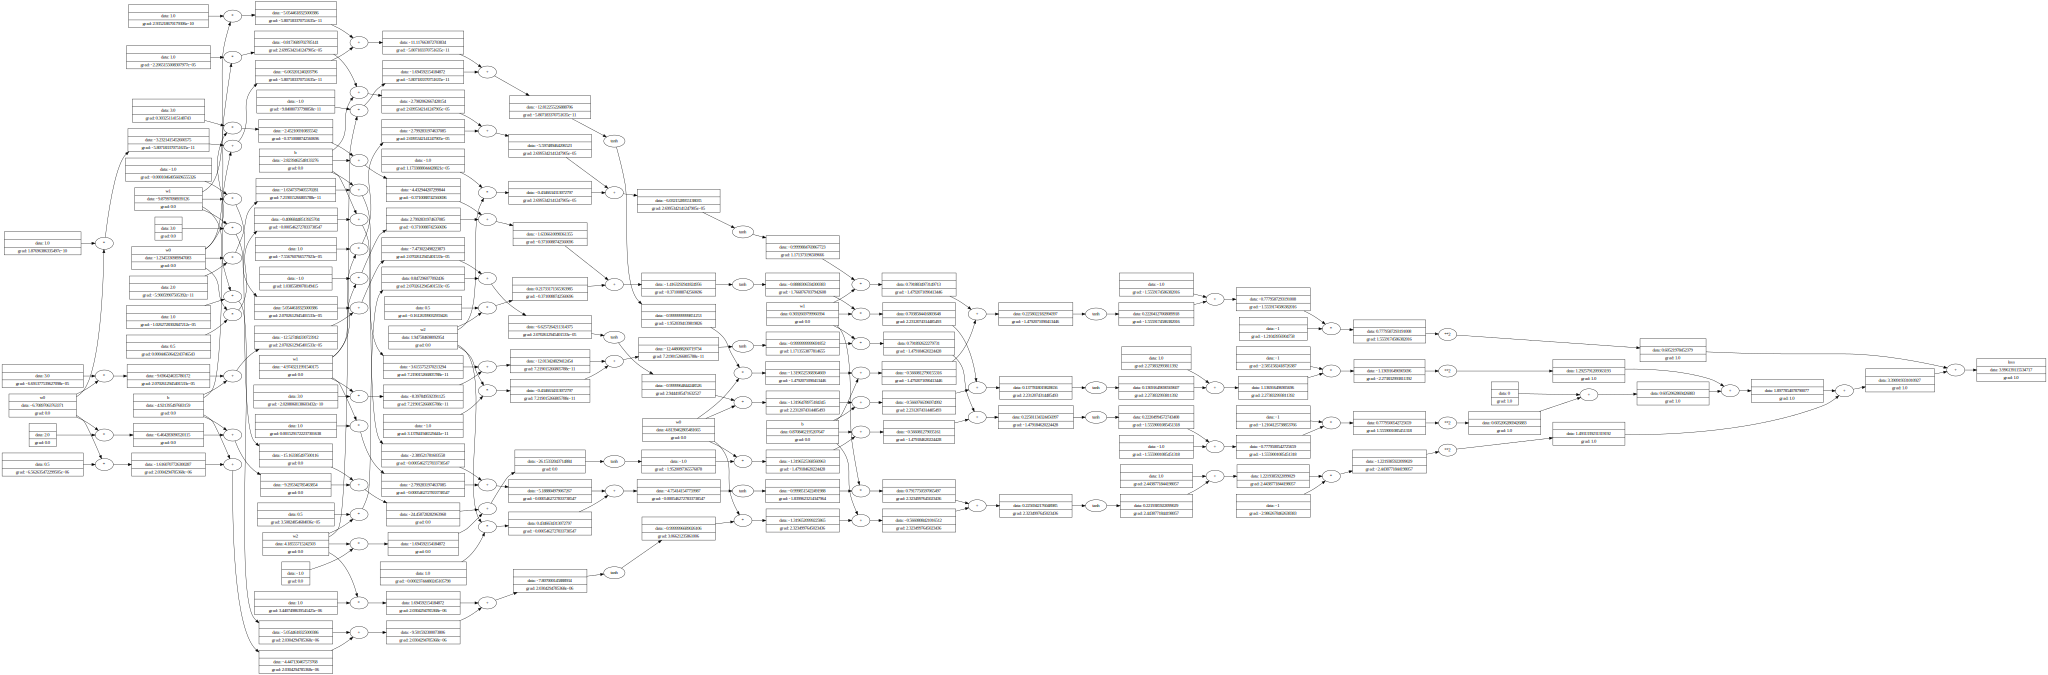

In [16]:
# y_preds.backprop()
draw_dot(loss)